In [ ]:
#############################
## For this version, training is done with two classes of mini-imagenet,
## further training / fine tuning is done with the second EEG dataset (MSU)
## The 1st dataset, EEG of Sz is split into a validation and test set

In [ ]:
!pip install scikit-plot

In [ ]:
import shutil
import pandas as pd
import numpy as np
import gdown
import os

# To improve the speed of setting up, retrieve only the files for the two groups used in training
# Swap with the line below to get the entire dataset as a zip file
# gdown.download('https://drive.google.com/uc?id=1-QTtycxsVNeym17zrMBSZCAAtEZEs05p', '/content/miniimagenet.zip', quiet=False)
gdown.download('https://drive.google.com/uc?id=1CZeMPRt4OZGJL_xQNfgi5evJW1PpA77l', '/content/miniimagenet.zip', quiet=False) # selected groups only
images_directory = '/content/miniimagenet/images/'
if not os.path.exists(images_directory):
  os.makedirs(images_directory) 
!unzip -qq /content/miniimagenet.zip -d {images_directory}


# get the CSV with the list of all file names
mini_imagenet_file_list_csv = '/content/all_imagenet_file_names.csv'
gdown.download('https://drive.google.com/uc?id=1-1JiyyEC6JlnEi0H0x-JKIGEKjdI_Nea', mini_imagenet_file_list_csv, quiet=False)
file_list = pd.read_csv(mini_imagenet_file_list_csv)

mini_imagenet_file_list = os.listdir(images_directory) #to exclude the directories created next
selected_groups = ['n01532829', 'n01558993']
for group_name in selected_groups:
  group_file = '/content/miniimagenet/images/' +  group_name
  if not os.path.isdir(group_file):
    os.makedirs(group_file)
samples_miniimagenet = file_list[file_list['label'].isin(selected_groups)].groupby('label').first()

# Other options for group pairs
# n01532829, n01558993
# n02108551, n02108915

for file in mini_imagenet_file_list:
  group = file[:9]
  file_dst = '/content/miniimagenet/images/{}/{}'.format(group, file)
  shutil.copyfile(images_directory + file, file_dst)

Downloading...
From: https://drive.google.com/uc?id=1CZeMPRt4OZGJL_xQNfgi5evJW1PpA77l
To: /content/miniimagenet.zip
59.8MB [00:01, 46.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-1JiyyEC6JlnEi0H0x-JKIGEKjdI_Nea
To: /content/all_imagenet_file_names.csv
2.27MB [00:00, 129MB/s]


In [ ]:
#Get the EEG spectrograms zip file and unzip it
eeg_image_directory = '/content/eeg_sz_spectrograms'
gdown.download('https://drive.google.com/uc?id=1WZ1yIFE2bng0McnY_4UBJHqTttsXTTNX', '{}.zip'.format(eeg_image_directory), quiet=False) 
!unzip -qq {eeg_image_directory}.zip -d {eeg_image_directory}

# rename 
dl_link = '/content/eeg_sz_spectrograms/gen_data_20s_70pct_overlap_-_high_nfft_all_channels_sml/'
!mv "{dl_link}/hc" {eeg_image_directory}
!mv "{dl_link}/sz" {eeg_image_directory}

Downloading...
From: https://drive.google.com/uc?id=1WZ1yIFE2bng0McnY_4UBJHqTttsXTTNX
To: /content/eeg_sz_spectrograms.zip
44.2MB [00:00, 55.6MB/s]


In [ ]:
# Get the spectrograms zip file for the fine tuning step
# For this version of the program, we attempt to use spectrograms from a different EEG dataset to fine-tune the program. The first EEG dataset will still be used for testing

fine_tuning_image_directory = '/content/fine_tuning_eeg_spectrograms'
gdown.download('https://drive.google.com/uc?id=1vSKS0I_ZoIaBVJAATqEGp_s8UcynWwPL', '{}.zip'.format(fine_tuning_image_directory), quiet=False) 
!unzip -qq {fine_tuning_image_directory}.zip -d {fine_tuning_image_directory}

# rename 
ft_dl_link = '{}/content/drive/My Drive/ML Projects/data/MSU.ru__gen_data_5s_70pct_overlap_-_fractional_noverlap_all_channels_sml/'.format(fine_tuning_image_directory)
!mv "{ft_dl_link}/hc" {fine_tuning_image_directory}
!mv "{ft_dl_link}/sz" {fine_tuning_image_directory}


Downloading...
From: https://drive.google.com/uc?id=1vSKS0I_ZoIaBVJAATqEGp_s8UcynWwPL
To: /content/fine_tuning_eeg_spectrograms.zip
117MB [00:00, 152MB/s] 


In [ ]:
#sorted([s.split('_')[0] for s in os.listdir(fine_tuning_image_directory + '/' + 'sz') ])

In [ ]:
# Use EEG of Sz for validation and testing
# Extract files from an eeg_sz spectrogram directory where files are saved by subject

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


rand_seed = 1
# List of raw patient file IDs that should be skipped based on categorization as outliers
ignore_list = ['h09', 'h10', 's10', 's11', 's12']
hc_subject_ids = ['hc' + str(i) for i in range(14) if "h{:02}".format(i) not in ignore_list] 
sz_subject_ids = ['sz' + str(i) for i in range(14) if "s{:02}".format(i) not in ignore_list] 
all_subject_ids = np.concatenate([hc_subject_ids, sz_subject_ids], axis=0)
validate_hc, test_hc = train_test_split(hc_subject_ids, test_size=0.5, random_state=rand_seed)
validate_sz, test_sz = train_test_split(sz_subject_ids, test_size=0.5, random_state=rand_seed)

validation_ids = np.concatenate([validate_hc, validate_sz])  # unused
test_ids = np.concatenate([test_hc, test_sz]) 


print('\nSubjects assigned to groups using sklearn.model_selection.train_test_split')
print('Test group: ', ", ".join(test_ids), "\n")
print('Validation group: ', ", ".join(validation_ids), "\n")

  

from shutil import copyfile
import pandas as pd
import os 


test_images_output_directory = 'all_test_images'
validation_images_output_directory = 'all_validation_images'

if not os.path.exists(test_images_output_directory):
    os.mkdir(test_images_output_directory)
if not os.path.exists(validation_images_output_directory):
    os.mkdir(validation_images_output_directory)



# Note: CSV is only used for MAML and Prototypical networks
def gen_csv_and_copy_sz_files(image_dir, img_output_dir, participant_ids, output_name, split_with_csv=False):
    subdir_data = []
    for group in ['hc', 'sz']: #['Healthy_Control', 'Sz_Patient']:
        for pid in os.listdir(image_dir + '/' + group): # by participant IDs
            if pid in participant_ids:
              for file in os.listdir(image_dir + '/' + group + '/' + pid):
                file_data = {'filename': file, 'label': group}
                subdir_data.append(file_data)
                destination = img_output_dir + '/' + file if split_with_csv else  '{}/{}/{}'.format(img_output_dir, group, file)
                if not os.path.exists('{}/{}'.format(img_output_dir, group)):
                  os.makedirs('{}/{}'.format(img_output_dir, group))
                copyfile(image_dir + '/' + group + '/' + pid + '/' + file,  destination )
    if split_with_csv:
      pd.DataFrame(subdir_data).to_csv(img_output_dir + '/' + output_name)
    return pd.DataFrame(subdir_data)


df = gen_csv_and_copy_sz_files(image_dir=eeg_image_directory, 
                                img_output_dir=test_images_output_directory,
                                participant_ids=test_ids,
                               split_with_csv=False,
                                output_name= 'test.csv')
df = gen_csv_and_copy_sz_files(image_dir=eeg_image_directory, 
                                img_output_dir=validation_images_output_directory,
                                participant_ids=validation_ids, 
                               split_with_csv=False,
                                output_name= 'val.csv')
print(df.head())




Subjects assigned to groups using sklearn.model_selection.train_test_split
Test group:  hc2, hc3, hc4, hc12, hc1, hc6, sz2, sz3, sz4, sz9, sz1, sz6 

Validation group:  hc0, hc7, hc13, hc11, hc8, hc5, sz0, sz7, sz13, sz8, sz5 

     filename label
0  hc0_22.png    hc
1  hc0_18.png    hc
2  hc0_20.png    hc
3  hc0_26.png    hc
4  hc0_11.png    hc


In [ ]:
###########################
### Process second training set (fine tuning set)

# Use EEG of Sz for testing
# Extract files from an eeg_sz spectrogram directory where files are saved by subject

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# List of raw patient file IDs that should be skipped based on categorization as outliers
ft_ignore_list = []
ft_hc_subject_ids = ['hc' + str(i) for i in range(38) if "h{:02}".format(i) not in ft_ignore_list] 
ft_sz_subject_ids = ['sz' + str(i) for i in range(38) if "s{:02}".format(i) not in ft_ignore_list] 
ft_all_subject_ids = np.concatenate([ft_hc_subject_ids, ft_sz_subject_ids], axis=0)

ft_images_output_directory = '/content/all_fine_tuning_images'

if not os.path.exists(ft_images_output_directory):
    os.mkdir(ft_images_output_directory)

print('\nAll subjects assigned to training group for fine tuning')
print(ft_all_subject_ids)

ids = { 'test': test_ids}
  


ft_df = gen_csv_and_copy_sz_files(image_dir=fine_tuning_image_directory, 
                                img_output_dir=ft_images_output_directory,
                                participant_ids=ft_all_subject_ids, 
                                split_with_csv = False,
                                output_name= 'train.csv')
print(ft_df.head())




All subjects assigned to training group for fine tuning
['hc0' 'hc1' 'hc2' 'hc3' 'hc4' 'hc5' 'hc6' 'hc7' 'hc8' 'hc9' 'hc10' 'hc11'
 'hc12' 'hc13' 'hc14' 'hc15' 'hc16' 'hc17' 'hc18' 'hc19' 'hc20' 'hc21'
 'hc22' 'hc23' 'hc24' 'hc25' 'hc26' 'hc27' 'hc28' 'hc29' 'hc30' 'hc31'
 'hc32' 'hc33' 'hc34' 'hc35' 'hc36' 'hc37' 'sz0' 'sz1' 'sz2' 'sz3' 'sz4'
 'sz5' 'sz6' 'sz7' 'sz8' 'sz9' 'sz10' 'sz11' 'sz12' 'sz13' 'sz14' 'sz15'
 'sz16' 'sz17' 'sz18' 'sz19' 'sz20' 'sz21' 'sz22' 'sz23' 'sz24' 'sz25'
 'sz26' 'sz27' 'sz28' 'sz29' 'sz30' 'sz31' 'sz32' 'sz33' 'sz34' 'sz35'
 'sz36' 'sz37']
      filename label
0  hc34_14.png    hc
1  hc34_32.png    hc
2  hc34_18.png    hc
3   hc34_9.png    hc
4  hc34_12.png    hc


In [ ]:
%cd /content

#!git clone https://github.com/zhangrong1722/CheXNet-Pytorch.git binaryCNN

gdown.download('https://drive.google.com/uc?id=1c1ADbwdNBxmN9jjzhcaCIIN5fD3BDCAc', 'main.py', quiet=False) 

train_directory ='/content/miniimagenet/images'
test_directory ='/content/all_test_images'
validation_directory = '/content/all_validation_images'
fine_tuning_directory ='/content/all_fine_tuning_images'


/content


Downloading...
From: https://drive.google.com/uc?id=1c1ADbwdNBxmN9jjzhcaCIIN5fD3BDCAc
To: /content/main.py
100%|██████████| 16.5k/16.5k [00:00<00:00, 4.14MB/s]


In [ ]:
!python main.py  --train_dir {train_directory} --fine_tuning_dir {fine_tuning_directory} --validation_dir {validation_directory} --test_dir {test_directory} --epochs 200 --fine_tuning_epochs 200


Streaming output truncated to the last 5000 lines.

Mode: fine tuning cycle   Epoch 40/200
----------
Train Epoch: 40 [0/2812 (0%)]	Loss: 1.989161
Train Epoch: 40 [120/2812 (4%)]	Loss: 8.255663
Train Epoch: 40 [240/2812 (9%)]	Loss: 9.911366
Train Epoch: 40 [360/2812 (13%)]	Loss: 18.733313
Train Epoch: 40 [480/2812 (17%)]	Loss: 15.227809
Train Epoch: 40 [600/2812 (21%)]	Loss: 12.342905
Train Epoch: 40 [720/2812 (26%)]	Loss: 8.308498
Train Epoch: 40 [840/2812 (30%)]	Loss: 7.095350
Train Epoch: 40 [960/2812 (34%)]	Loss: 17.809505
Train Epoch: 40 [1080/2812 (38%)]	Loss: 8.439089
Train Epoch: 40 [1200/2812 (43%)]	Loss: 19.333134
Train Epoch: 40 [1320/2812 (47%)]	Loss: 10.785610
Train Epoch: 40 [1440/2812 (51%)]	Loss: 6.795227
Train Epoch: 40 [1560/2812 (55%)]	Loss: 5.121434
Train Epoch: 40 [1680/2812 (60%)]	Loss: 6.888049
Train Epoch: 40 [1800/2812 (64%)]	Loss: 7.999932
Train Epoch: 40 [1920/2812 (68%)]	Loss: 8.568033
Train Epoch: 40 [2040/2812 (72%)]	Loss: 4.996950
Train Epoch: 40 [2160/28

In [ ]:
import matplotlib.pyplot as plt
import itertools

# modified from main.py https://github.com/zhangrong1722/CheXNet-Pytorch

def plt_roc(test_y, probas_y, plot_micro=False, plot_macro=False):
    assert isinstance(test_y, list) and isinstance(probas_y, list), 'the type of input must be list'
    skplt.metrics.plot_roc(test_y, probas_y, plot_micro=plot_micro, plot_macro=plot_macro)
    plt.savefig('roc_auc_curve.png')
    plt.show()
    plt.close()


###########################################
# Define confusion matrix and ROC visualization functions
# from https://colab.research.google.com/drive/1ISfhxFDntfOos7cOeT7swduSqzLEqyFn#scrollTo=UiKRYOWPfhJs

def plot_confusion_matrix(cm, classes=None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          cv=10):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("\nNormalized confusion matrix")
    else:
        print('\nConfusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    if classes:
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.locator_params(nbins=2)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:
best_model_preds = pd.read_csv('best_val_model_predictions.csv')
pred_y = best_model_preds['pred_y'].values
test_y = best_model_preds['test_y'].values
probas_y = [s.replace('[', '').replace(']', '').split(', ') for s in best_model_preds['probas_y'].values]
probas_y = [[float(t[0]), float(t[1])] for t in probas_y]


Confusion matrix, without normalization


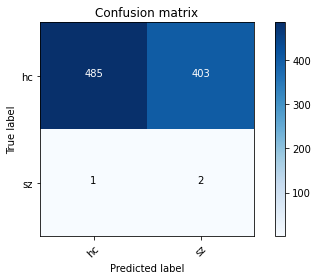

In [ ]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(pred_y, test_y)
plot_confusion_matrix(confusion,
                      classes=['hc', 'sz'],
                      title='Confusion matrix')


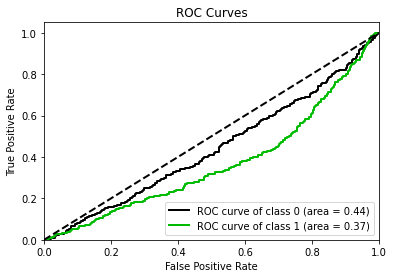

In [ ]:
!pip install scikit_plot
import scikitplot as skplt
plt_roc(list(test_y), list(probas_y))

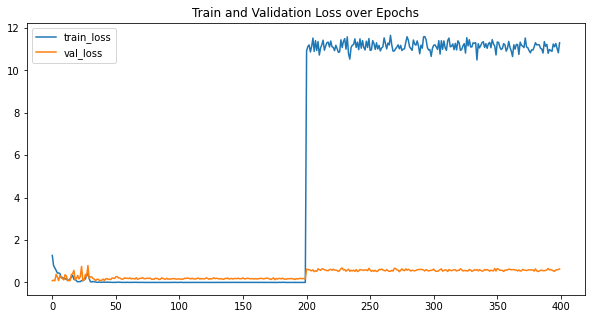

In [ ]:
metrics = pd.read_csv('metrics_by_epoch.csv')
metrics.head()
#TODO chart these values

metrics[['train_loss', 'val_loss']].plot(figsize=(10,5), title='Train and Validation Loss over Epochs')

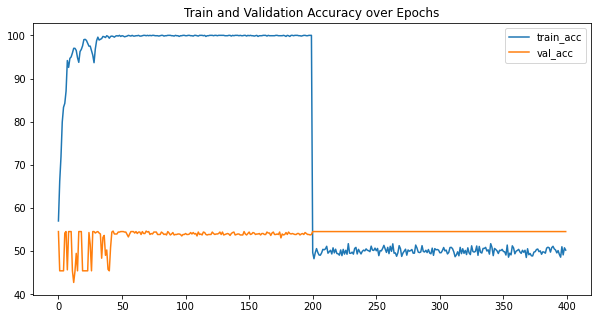

In [ ]:
metrics[['train_acc', 'val_acc']].plot(figsize=(10,5), title='Train and Validation Accuracy over Epochs')

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

auc = roc_auc_score(test_y, pred_y)
print('AUC score for validation set: ', auc)


f1_macro = f1_score(test_y, pred_y, average='macro')
f1_micro = f1_score(test_y, pred_y, average='micro')

print('F1 score (average=macro): {}     F1 score (average=micro): {}'.format(f1_macro, f1_micro))


AUC score for validation set:  0.5014403292181069
F1 score (average=macro): 0.35788594913948113     F1 score (average=micro): 0.5465768799102132
